In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats

import os, sys

project_root = '/user_data/mmhender/featsynth/'
sys.path.insert(0, os.path.join(project_root, 'code'))
from utils import stats_utils, plot_utils

import get_gram_matrix_distances

figpath = os.path.join(project_root, 'figures_raw')

In [2]:
# load image info
image_set_name = 'images_ecoset64'
image_list_filename = os.path.join(project_root, 'features','raw', '%s_list.csv'%(image_set_name))
labels = pd.read_csv(image_list_filename)

# figure out some image/category properties here
n_ims_each = np.sum(np.array(labels['basic_name'])==np.array(labels['basic_name'])[0])
basic_names = np.array(labels['basic_name'][0::n_ims_each])
super_names_long = np.array(labels['super_name'][0::n_ims_each])

n_basic = len(basic_names)
n_super = len(np.unique(super_names_long))
n_basic_each_super  = int(n_basic/n_super)
super_names = super_names_long[0::n_basic_each_super]
super_inds_long = np.repeat(np.arange(n_super), n_basic_each_super)

# more image properties to organize images
image_type_names = ['orig']
n_image_types = len(image_type_names)
cue_level_names = ['basic','super']

In [3]:
labels.shape

(32000, 8)

In [4]:
ecoset_info_path = '/user_data/mmhender/stimuli/ecoset_info/'
fn = os.path.join(ecoset_info_path, 'categ_use_ecoset.npy')
info = np.load(fn, allow_pickle=True).item()

#### get all the cosine distances

In [5]:
layer_names = ['pool1','pool2','pool3','pool4']
# layer_names = ['pool1','pool2', 'pool3']
n_layers = len(layer_names)

n_ims_vals =np.arange(8, 500, 8)
n_v = len(n_ims_vals)

fn = os.path.join(project_root, 'features', 'gram_matrices', 'distances', \
                  'cosine_distances_%s.npy'%image_set_name)
d = np.load(fn, allow_pickle=True).item()

within_b = d['within_b']
across_b_within_s = d['across_b_within_s']
across_b_all = d['across_b_all']
within_s = d['within_s']
across_s = d['across_s']

#### get ratio of across to within

In [6]:
basic_sep = across_b_within_s / within_b 
basic_sep_all = across_b_all / within_b 
super_sep_each_supcat = across_s / within_s

#### average across all the basic-level categs in each superordinate category

In [7]:
within_b_each_supcat = np.array([np.mean(within_b[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])
across_b_within_s_each_supcat = np.array([np.mean(across_b_within_s[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])
across_b_all_each_supcat = np.array([np.mean(across_b_all[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])


basic_sep_each_supcat = np.array([np.mean(basic_sep[super_inds_long==si,:], axis=0) \
                                   for si in range(n_super)])

basic_sep_all_each_supcat = np.array([np.mean(basic_sep_all[super_inds_long==si,:], axis=0) \
                                   for si in range(n_super)])

(8, 4)
[1.0363867  1.04167439 1.06397881 1.09549397] [0.01654141 0.01521507 0.02585051 0.04271009]
(8, 4)
[1.02466943 1.02754247 1.03798963 1.0525875 ] [0.01053791 0.01665292 0.02119047 0.02860708]
/user_data/mmhender/featsynth/figures_raw/ecoset64_cosine_sep.pdf


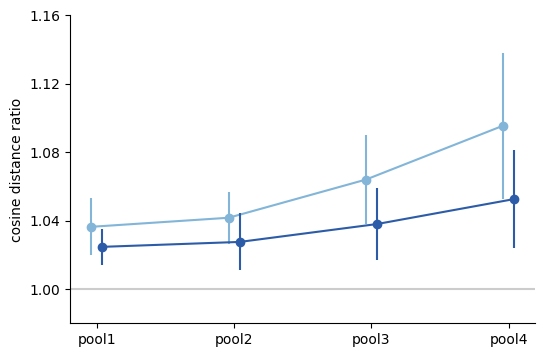

In [16]:
# level_colors = np.array([[93,192,219], [44,92,168]])/255
level_colors = np.array([[130, 181, 216], [44,92,168]])/255
level_names = ['Fine','Coarse']

ni = 11;

lh = []

plt.rcParams['pdf.fonttype']=42


plt.figure(figsize=(6,4))
ax = plt.subplot(1,1,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

jitters = [-0.04, 0.04]
    
# for cc, vals in enumerate([basic_sep[:,:,ni], super_sep_each_supcat[:,:,ni]]):
for cc, vals in enumerate([basic_sep_each_supcat[:,:,ni], super_sep_each_supcat[:,:,ni]]):

    print(vals.shape)
    # for xi in range(vals.shape[0]):

    #     plt.plot(vals[xi,:], '-', color=level_colors[cc,:])
    m = np.mean(vals, axis=0)
    s = np.std(vals, axis=0)
    print(m, s)
    x = np.arange(vals.shape[1])+jitters[cc]
    h = plt.plot(x, m, 'o-', color=level_colors[cc,:])
    plt.errorbar(x, m, s, \
                 color=level_colors[cc,:], linestyle='none')
    
    lh+=[h[0]]

plt.xticks(np.arange(n_layers), layer_names)

# plt.legend(lh, level_names)

plt.axhline(1.0, color=[0.8, 0.8, 0.8])

plt.ylabel('cosine distance ratio')

# plt.title('category separability, %d images'%n_ims_vals[ni])

# plt.xlabel('layer')

plt.ylim([0.98, 1.16])

plt.yticks(np.arange(1, 1.161, 0.04))

fn2save = os.path.join(figpath,'ecoset64_cosine_sep.pdf')
print(fn2save)
plt.savefig(fn2save, transparent=True)

In [17]:
b_pair_dist = np.zeros((n_basic, n_basic, n_layers))
s_pair_dist = np.zeros((n_super, n_super, n_layers))

for ll in range(n_layers):
        
    basic_pair, super_pair = get_gram_matrix_distances.compute_pairwise_distances_ecoset(\
                          image_set_name = 'images_ecoset64', 
                          layers_process = [layer_names[ll]], 
                          distance_metric='cosine', \
                          n_per_categ = 96, \
                          n_comp_keep = 100)

    b_pair_dist[:,:,ll] = basic_pair
    s_pair_dist[:,:,ll] = super_pair

/user_data/mmhender/featsynth/features/gram_matrices/images_ecoset64_gram_matrices_pool1_pca.npy
(32000, 100)
total ims subsampled for basic: 6144
total ims subsampled for super: 768
/user_data/mmhender/featsynth/features/gram_matrices/images_ecoset64_gram_matrices_pool2_pca.npy
(32000, 100)
total ims subsampled for basic: 6144
total ims subsampled for super: 768
/user_data/mmhender/featsynth/features/gram_matrices/images_ecoset64_gram_matrices_pool3_pca.npy
(32000, 100)
total ims subsampled for basic: 6144
total ims subsampled for super: 768
/user_data/mmhender/featsynth/features/gram_matrices/images_ecoset64_gram_matrices_pool4_pca.npy
(32000, 100)
total ims subsampled for basic: 6144
total ims subsampled for super: 768


/user_data/mmhender/featsynth/figures_raw/pool1_pairwise.pdf
/user_data/mmhender/featsynth/figures_raw/pool4_pairwise.pdf


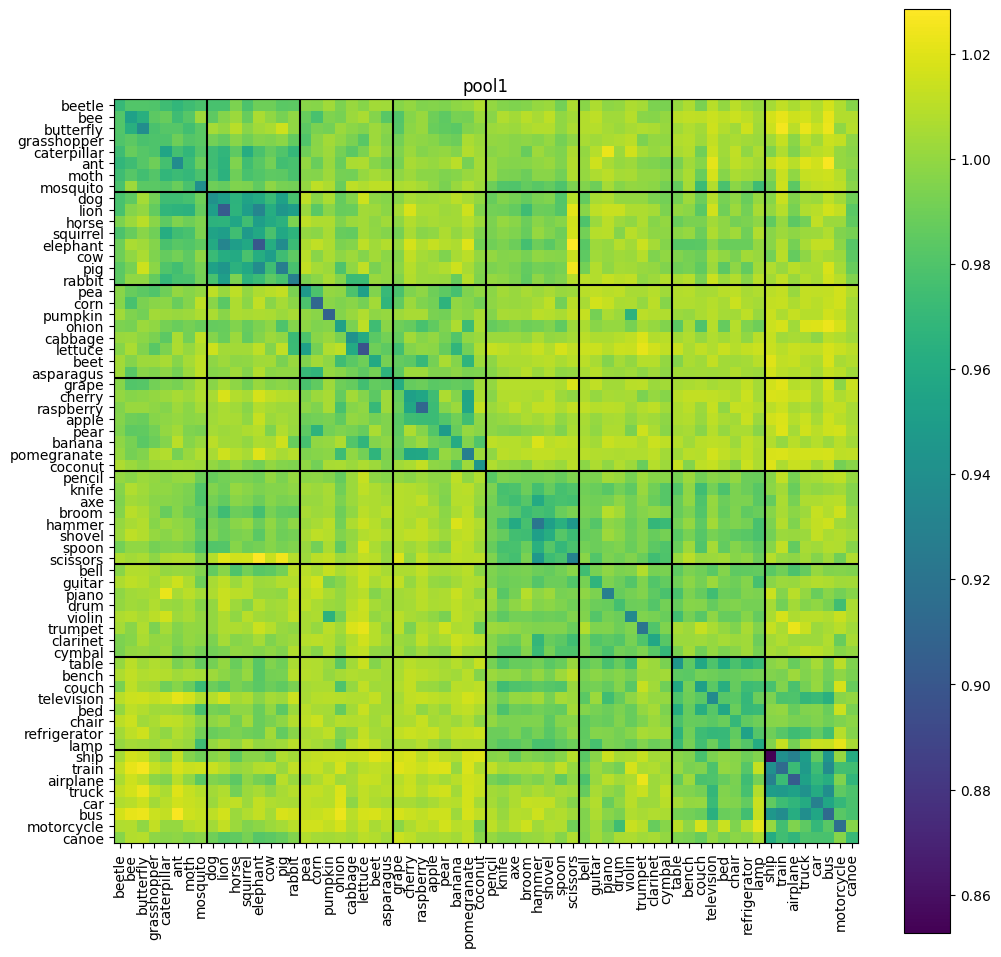

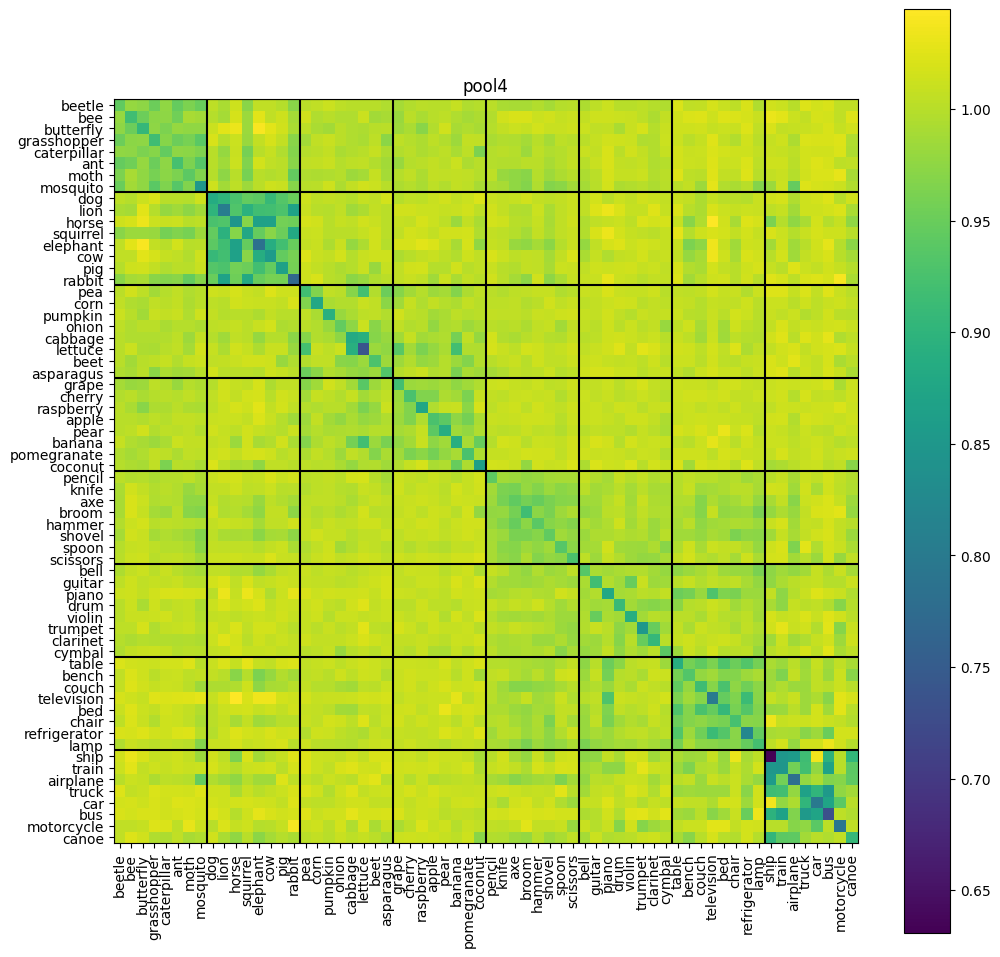

In [25]:
plt.rcParams['pdf.fonttype']=42


for ll in [0,3]:
    
    
    d = b_pair_dist[:,:,ll]
    
    plt.figure(figsize=(12, 12))
    plt.pcolormesh(d, \
                   # vmin=0.37, vmax=1.10, \
                  )
    plt.xticks(np.arange(n_basic)+0.5, basic_names, rotation=90)
    plt.yticks(np.arange(n_basic)+0.5, basic_names)
    
    for si in range(n_super):
        plt.axhline(si*n_basic_each_super, color='k')
        plt.axvline(si*n_basic_each_super, color='k')
    
    plt.axis('square')
    plt.colorbar()

    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    plt.title(layer_names[ll])
    
    fn2save = os.path.join(figpath,'%s_pairwise.pdf'%(layer_names[ll]))
    print(fn2save)
    plt.savefig(fn2save, transparent=True)

In [21]:
within_b_each_supcat.shape

(8, 4, 62)

#### plot average separability of each type

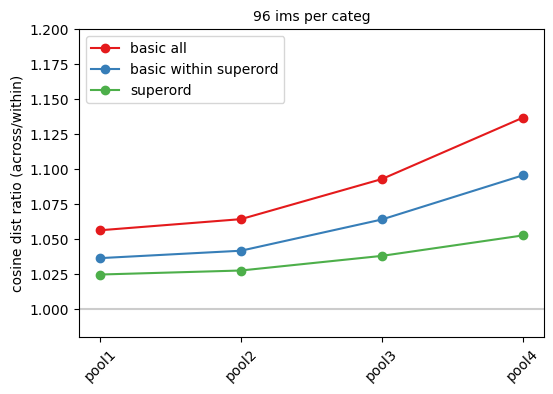

In [9]:
for ni in [11]:

    plot_utils.set_all_font_sizes(10)

    xjitters =np.linspace(-0.05, 0.05, 3)

    cue_level_colors = cm.Set1(np.linspace(0,1,9))[0:3,:]

    point_types = ['o','x']
    markersize = 4;


    plt.figure(figsize=(6,4))

    ax = plt.subplot(1,1,1)
        # lh = []

    vals1 = np.mean(basic_sep_all[:,:,ni], axis=0)
    vals2 = np.mean(basic_sep[:,:,ni], axis=0)
    vals3 = np.mean(super_sep_each_supcat[:,:,ni], axis=0)
    levels = ['basic all','basic within superord','superord']

    for cc, vals in enumerate([vals1, vals2, vals3]):

        h = plt.plot(np.arange(n_layers), vals,\
                 'o-',color=cue_level_colors[cc,:])

        # lh.append(h[0])

        plt.xticks(np.arange(n_layers), layer_names,rotation=45)


    plt.axhline(1.0, color=[0.8, 0.8, 0.8], linestyle='-')

    # ax.legend(lh, np.repeat(cue_level_vals,2), loc='lower right')
    ax.legend(levels, loc='upper left')

    plt.ylabel('cosine dist ratio (across/within)')

    plt.title('%d ims per categ'%n_ims_vals[ni])
    plt.ylim([0.98, 1.20])



Text(0.5, 1.0, '96 ims per categ')

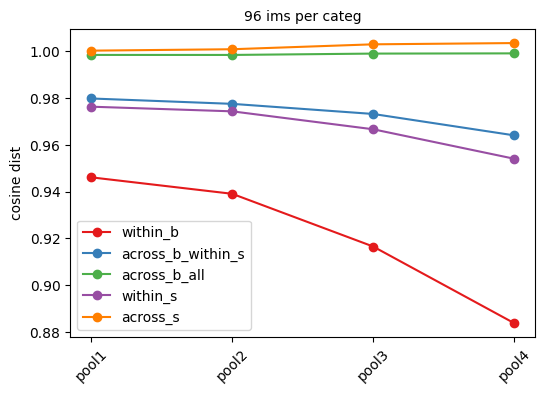

In [10]:
colors = cm.Set1(np.linspace(0,1,9))[0:5,:]

ni = 11

plot_utils.set_all_font_sizes(10)

xjitters =np.linspace(-0.05, 0.05, 3)

point_types = ['o','x']
markersize = 4;


plt.figure(figsize=(6,4))

ax = plt.subplot(1,1,1)
    # lh = []

names = list(d.keys())

for nn, name in enumerate(names):

    vals = np.mean(d[name][:,:,ni], axis=0)
    
    h = plt.plot(np.arange(n_layers), vals,\
             'o-',color=colors[nn,:])

    # lh.append(h[0])

    plt.xticks(np.arange(n_layers), layer_names,rotation=45)


# plt.axhline(0, color=[0.8, 0.8, 0.8], linestyle='--')

# ax.legend(lh, np.repeat(cue_level_vals,2), loc='lower right')
ax.legend(names, loc='lower left')

plt.ylabel('cosine dist')

plt.title('%d ims per categ'%n_ims_vals[ni])
# plt.ylim([1.0, 1.04])


In [16]:
basic_sep.shape

(64, 4, 62)

In [17]:
super_sep_each_supcat.shape

(8, 4, 62)

In [29]:
m, s

(array([1.02466943, 1.02754247, 1.03798963, 1.0525875 ]),
 array([0.01053791, 0.01665292, 0.02119047, 0.02860708]))

In [24]:
within_b_each_supcat[:,:,ni]

array([[0.95444331, 0.95118754, 0.93647499, 0.90907951],
       [0.93420378, 0.91431992, 0.88545066, 0.83451198],
       [0.92863717, 0.93022918, 0.9217607 , 0.89763216],
       [0.94442689, 0.94206784, 0.91504861, 0.90630166],
       [0.97040896, 0.96763082, 0.96179389, 0.9439092 ],
       [0.96202716, 0.94698148, 0.93719818, 0.90031938],
       [0.95908627, 0.94924672, 0.91704757, 0.88208013],
       [0.91529819, 0.91055471, 0.8570328 , 0.79587534]])

In [25]:
super_sep_each_supcat[:,:,ni]

array([[1.02752844, 1.02776118, 1.04213604, 1.05041871],
       [1.03956623, 1.06006412, 1.06961464, 1.11104987],
       [1.02046862, 1.02070255, 1.02288964, 1.03521014],
       [1.02507933, 1.01422788, 1.02386912, 1.03077158],
       [1.01537402, 1.01525415, 1.01701544, 1.02869825],
       [1.00985163, 1.01741282, 1.01781351, 1.02662844],
       [1.01784798, 1.01464223, 1.03655424, 1.05214373],
       [1.04163922, 1.05027481, 1.07402438, 1.08577929]])

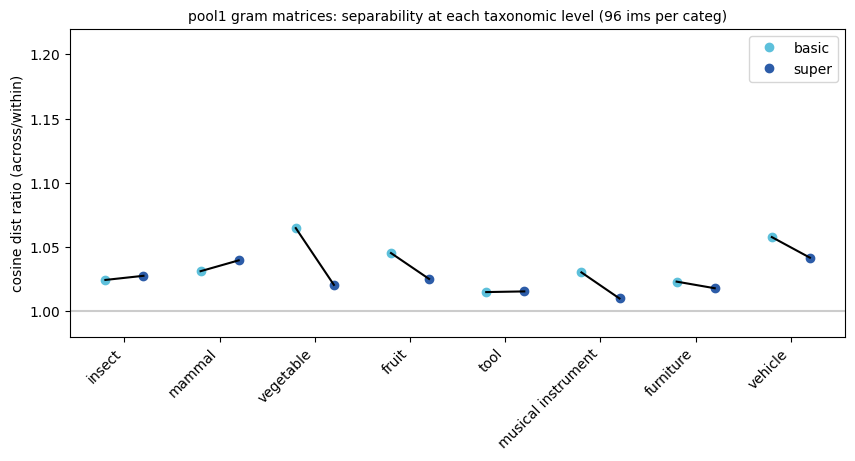

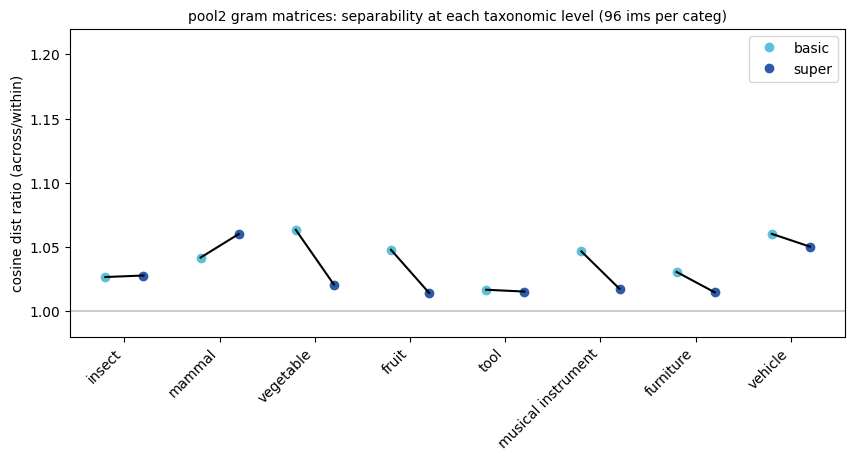

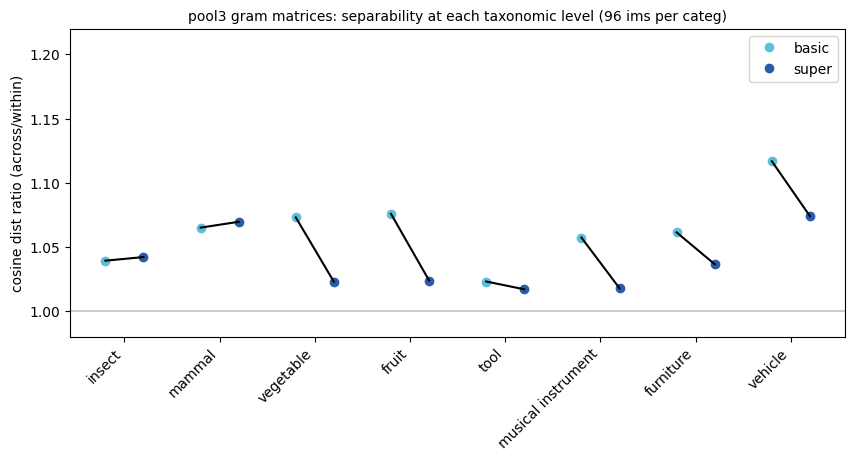

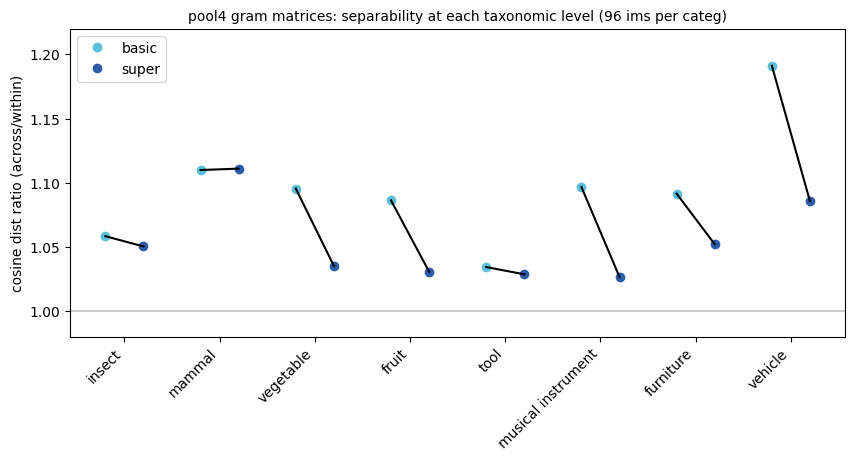

In [48]:
level_colors = np.array([[93,192,219], [44,92,168]])/255
level_names = ['basic','super']

ni = 11;
# ni = 4;

vals = np.array([basic_sep_each_supcat[:,:,ni], super_sep_each_supcat[:,:,ni]])

xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

for ii in range(n_layers):
    
    
    plt.figure(figsize=(10,4))
    
    lh=[]
    for ca in range(n_super):
    
        for cc in range(2):
            h = plt.plot(ca+xjitters[cc], vals[cc,ca,ii], \
                    'o', color=level_colors[cc,:])
            if ca==0:
                lh+=h
    
        plt.plot(ca+xjitters, vals[:,ca, ii], color='k')
    
    plt.xticks(np.arange(n_super), super_names, rotation=45, ha='right')
    
    plt.axhline(1, color=[0.8, 0.8, 0.8])
    
    plt.title('%s gram matrices: separability at each taxonomic level (%d ims per categ)'%\
              (layer_names[ii], n_ims_vals[ni]))
    
    plt.legend(lh, level_names)
    
    plt.ylabel('cosine dist ratio (across/within)')

    plt.ylim([0.98, 1.22])

#### separate into natural and artificial superord categories

In [28]:
is_natural = np.array([1,1,1,1,0,0,0,0]).astype(bool)
kind_names = ['Artificial','Natural']
n_kinds = len(kind_names)
nat_colors = cm.Greens(np.linspace(0,1,5))[[2,3],:]

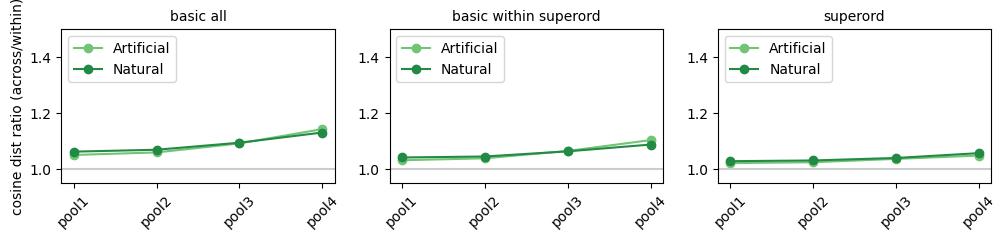

In [42]:
ni = 11;

levels = ['basic all','basic within superord','superord']

plt.figure(figsize=(12,2))
pi=0

for vals, level in zip([basic_sep_all_each_supcat[:,:,ni], \
                        basic_sep_each_supcat[:,:,ni], \
                        super_sep_each_supcat[:,:,ni]], \
                      levels):
        
    pi+=1
    ax = plt.subplot(1,3,pi)
    
    lh = []
    
    for kk in [0,1]:

        # print(kk)
    
        meanvals = np.mean(vals[is_natural==kk,:], axis=0)
    
        h = plt.plot(np.arange(n_layers), meanvals, 'o-', color=nat_colors[kk,:])
    
        lh += h
        
    ax.legend(lh, kind_names, loc='upper left');
    plt.xticks(np.arange(n_layers), layer_names, rotation=45);

    plt.axhline(1, color=[0.8, 0.8, 0.8])
    
    if pi==1:
        plt.ylabel('cosine dist ratio (across/within)')
    
    plt.ylim([0.95, 1.50])
    
    plt.title(level)

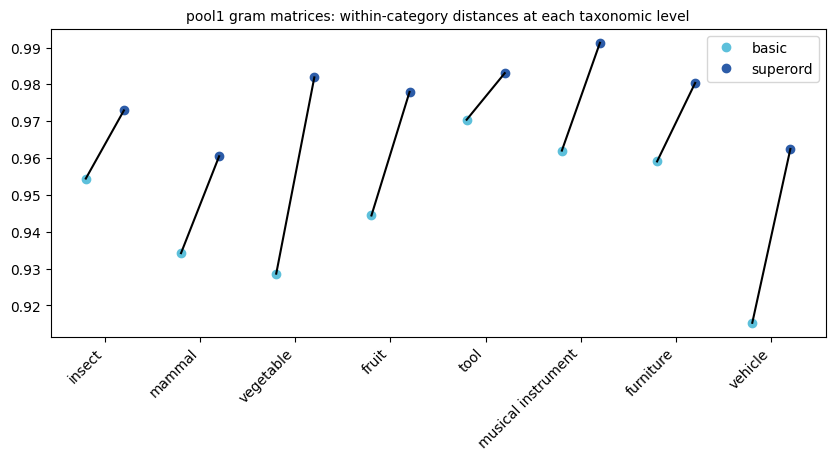

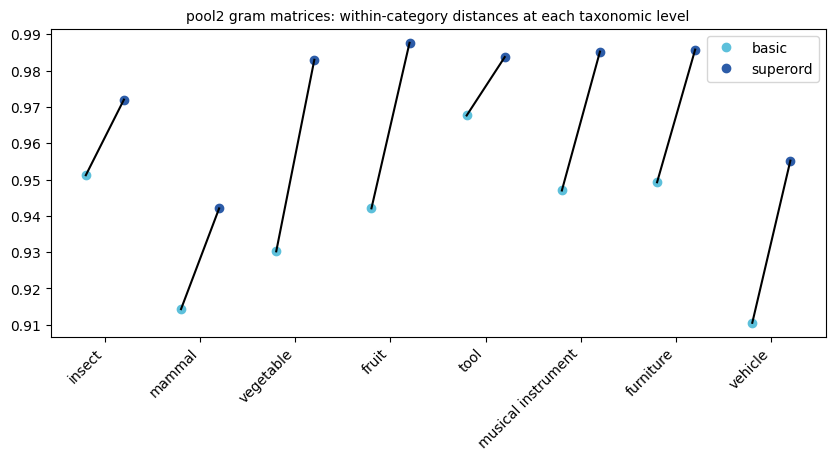

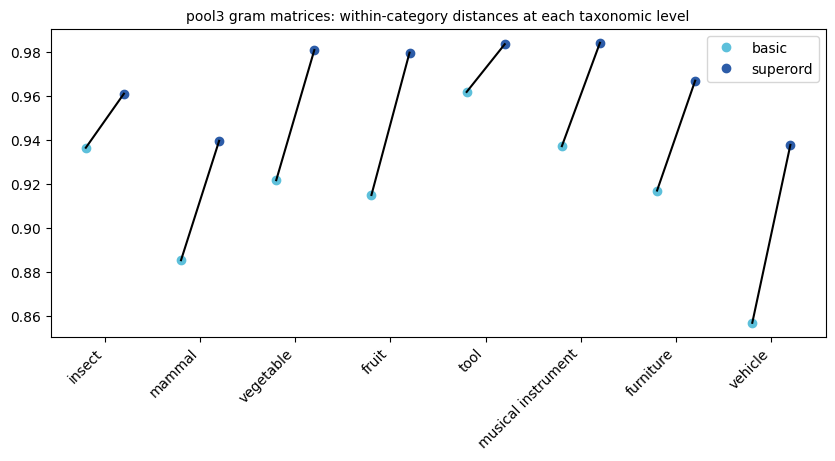

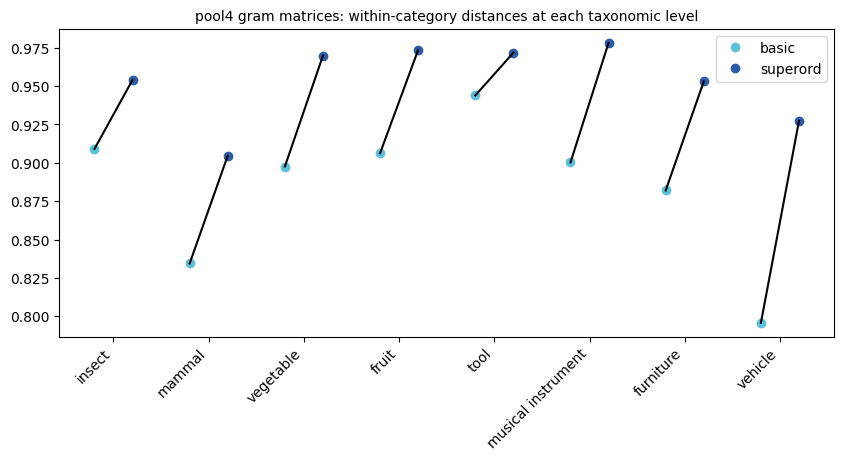

In [44]:
level_colors = np.array([[93,192,219], [44,92,168]])/255

ni  =11;

vals = np.array([within_b_each_supcat[:,:,ni], within_s[:,:,ni]])
xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

for ii in range(n_layers):

    
    plt.figure(figsize=(10,4))
    
    lh=[]
    for ca in range(n_super):
    
        for cc in range(2):
            h = plt.plot(ca+xjitters[cc], vals[cc,ca,ii], \
                    'o', color=level_colors[cc,:])
            if ca==0:
                lh+=h
    
        plt.plot(ca+xjitters, vals[:,ca, ii], color='k')
    
    plt.xticks(np.arange(n_super), super_names, rotation=45, ha='right')
    
    # plt.axhline(1, color=[0.8, 0.8, 0.8])
    
    plt.legend(lh, ['basic','superord'])
    
    plt.title('%s gram matrices: within-category distances at each taxonomic level'%layer_names[ii])


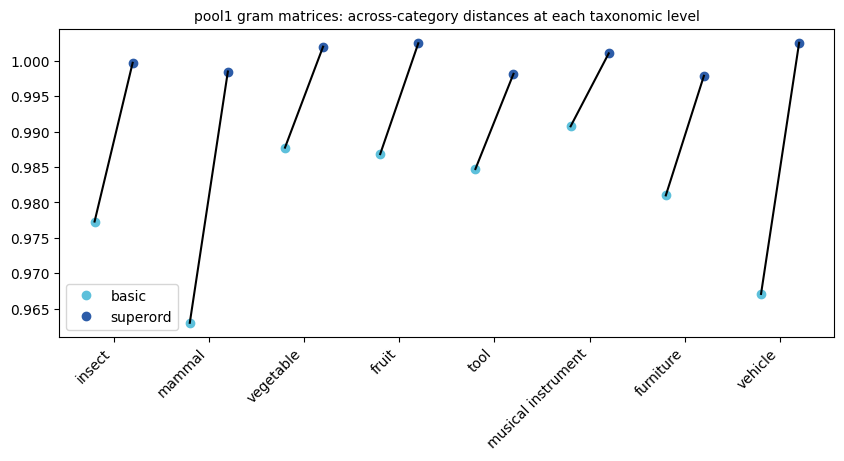

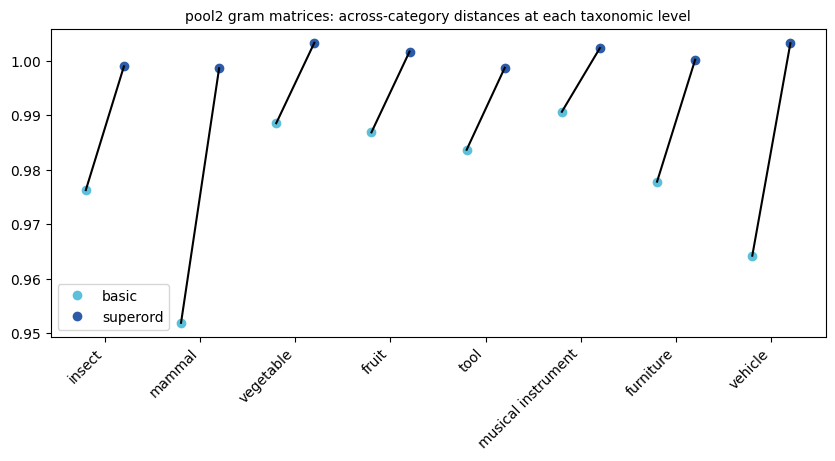

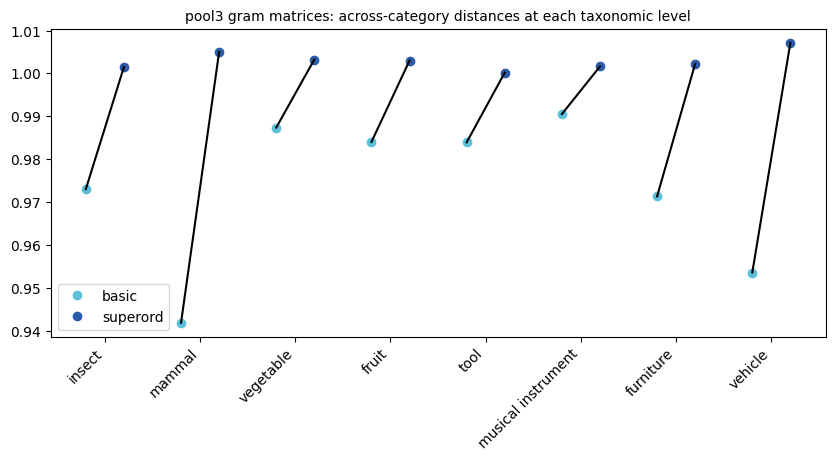

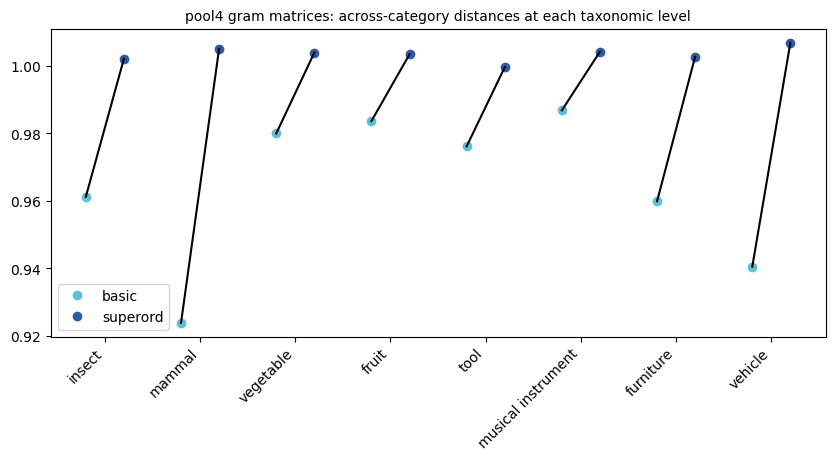

In [46]:
ni = 11;

vals = np.array([across_b_within_s_each_supcat[:,:,ni], across_s[:,:,ni]])

xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

for ii in range(n_layers):
    
    plt.figure(figsize=(10,4))
    
    lh=[]
    for ca in range(n_super):
    
        for cc in range(2):
            h = plt.plot(ca+xjitters[cc], vals[cc,ca,ii], \
                    'o', color=level_colors[cc,:])
            if ca==0:
                lh+=h
    
        plt.plot(ca+xjitters, vals[:,ca, ii], color='k')
    
    plt.xticks(np.arange(n_super), super_names, rotation=45, ha='right')
    
    # plt.axhline(1, color=[0.8, 0.8, 0.8])
    
    
    plt.legend(lh, ['basic','superord'])
    
    plt.title('%s gram matrices: across-category distances at each taxonomic level'%layer_names[ii])


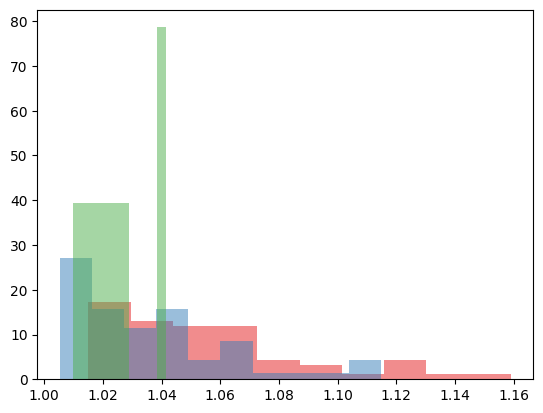

In [47]:
li = 0;
ni = 11;

cue_level_colors = cm.Set1(np.linspace(0,1,9))[0:3,:]

plt.figure()

for vi, vals in enumerate([basic_sep_all[:,li,ni], \
                         basic_sep[:,li,ni], \
                         super_sep_each_supcat[:,li,ni]]):
    
    plt.hist(vals, alpha=0.5, color=cue_level_colors[vi,:], density=True)

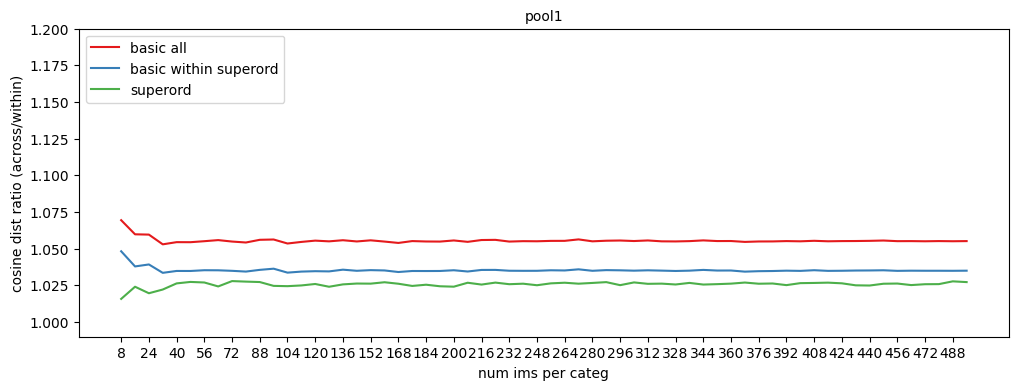

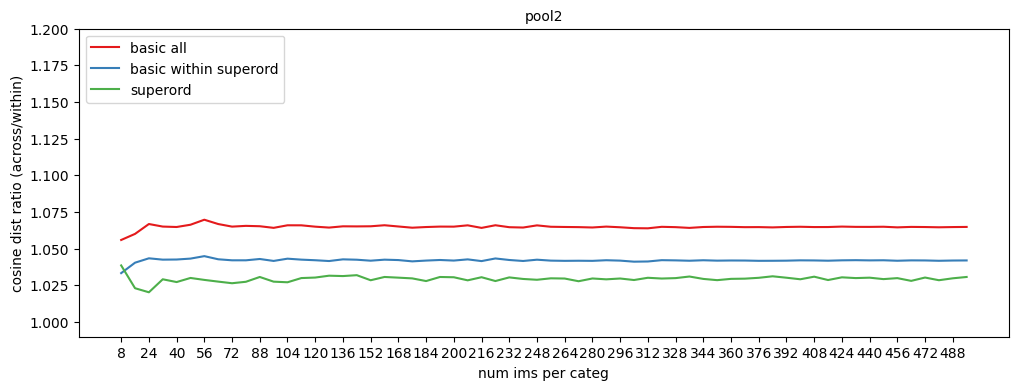

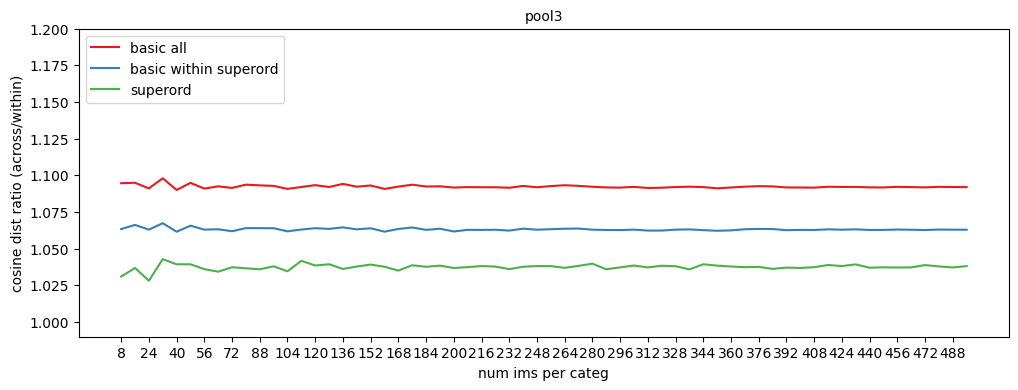

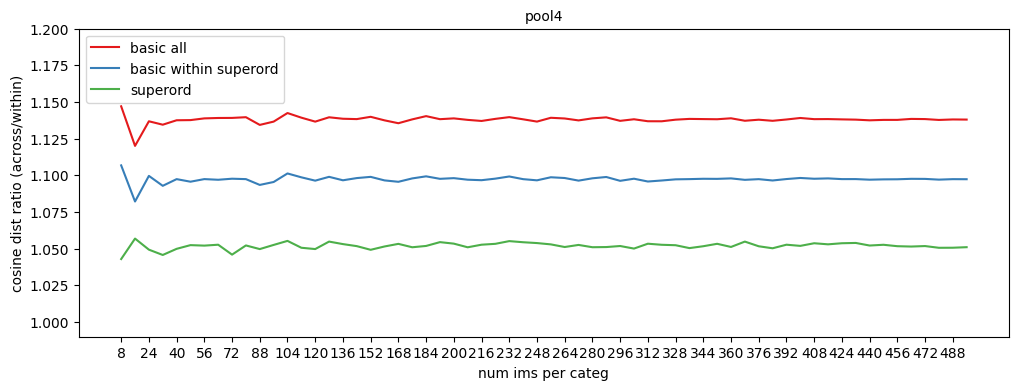

In [9]:
for li in range(n_layers):

    plot_utils.set_all_font_sizes(10)

    cue_level_colors = cm.Set1(np.linspace(0,1,9))[0:3,:]

    plt.figure(figsize=(12,4))

    ax = plt.subplot(1,1,1)
        # lh = []

    vals1 = np.mean(basic_sep_all[:,li,:], axis=0)
    vals2 = np.mean(basic_sep[:,li,:], axis=0)
    vals3 = np.mean(super_sep_each_supcat[:,li,:], axis=0)
    levels = ['basic all','basic within superord','superord']

    for cc, vals in enumerate([vals1, vals2, vals3]):
    # for cc, vals in enumerate([vals1,  vals3]):

        h = plt.plot(np.arange(n_v), vals,\
                 '-',color=cue_level_colors[cc,:])

        # lh.append(h[0])

    tick_inds_plot = np.arange(0, n_v, 2)
    plt.xticks(tick_inds_plot, n_ims_vals[tick_inds_plot], rotation=0)

        
    plt.xlabel('num ims per categ')

    # plt.axhline(0, color=[0.8, 0.8, 0.8], linestyle='--')

    # ax.legend(lh, np.repeat(cue_level_vals,2), loc='lower right')
    ax.legend(levels, loc='upper left')

    plt.ylabel('cosine dist ratio (across/within)')

    plt.title('%s'%layer_names[li])
    plt.ylim([0.99, 1.20])



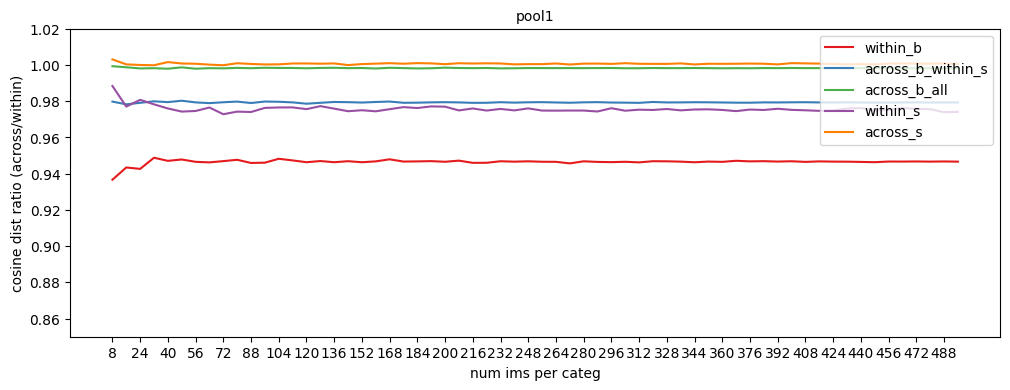

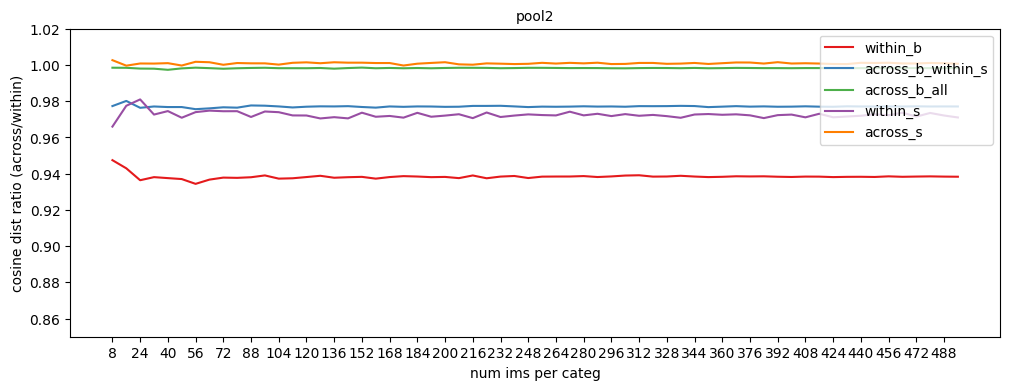

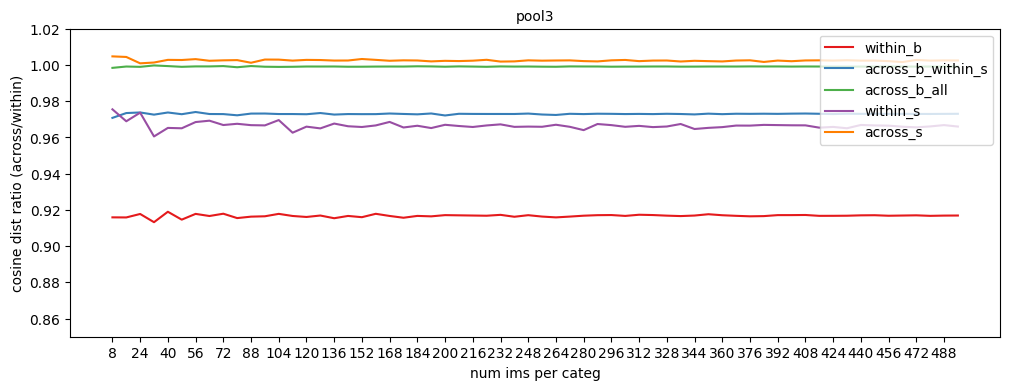

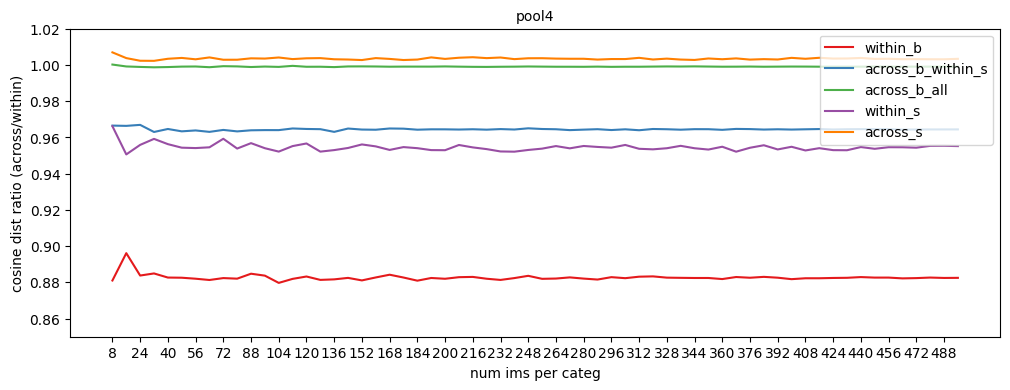

In [10]:
for li in range(n_layers):

    plot_utils.set_all_font_sizes(10)

    colors = cm.Set1(np.linspace(0,1,9))[0:5,:]

    plt.figure(figsize=(12,4))

    ax = plt.subplot(1,1,1)
        # lh = []

    names = d.keys()
    
    for cc, name in enumerate(names):
        
        vals = np.mean(d[name][:,li,:], axis=0)
    
        h = plt.plot(np.arange(n_v), vals,\
                 '-',color=colors[cc,:])

        # lh.append(h[0])

    tick_inds_plot = np.arange(0, n_v, 2)
    plt.xticks(tick_inds_plot, n_ims_vals[tick_inds_plot], rotation=0)

        
    plt.xlabel('num ims per categ')

    # plt.axhline(0, color=[0.8, 0.8, 0.8], linestyle='--')

    # ax.legend(lh, np.repeat(cue_level_vals,2), loc='lower right')
    ax.legend(names, loc='upper right')

    plt.ylabel('cosine dist ratio (across/within)')

    plt.title('%s'%layer_names[li])
    plt.ylim([0.85, 1.02])



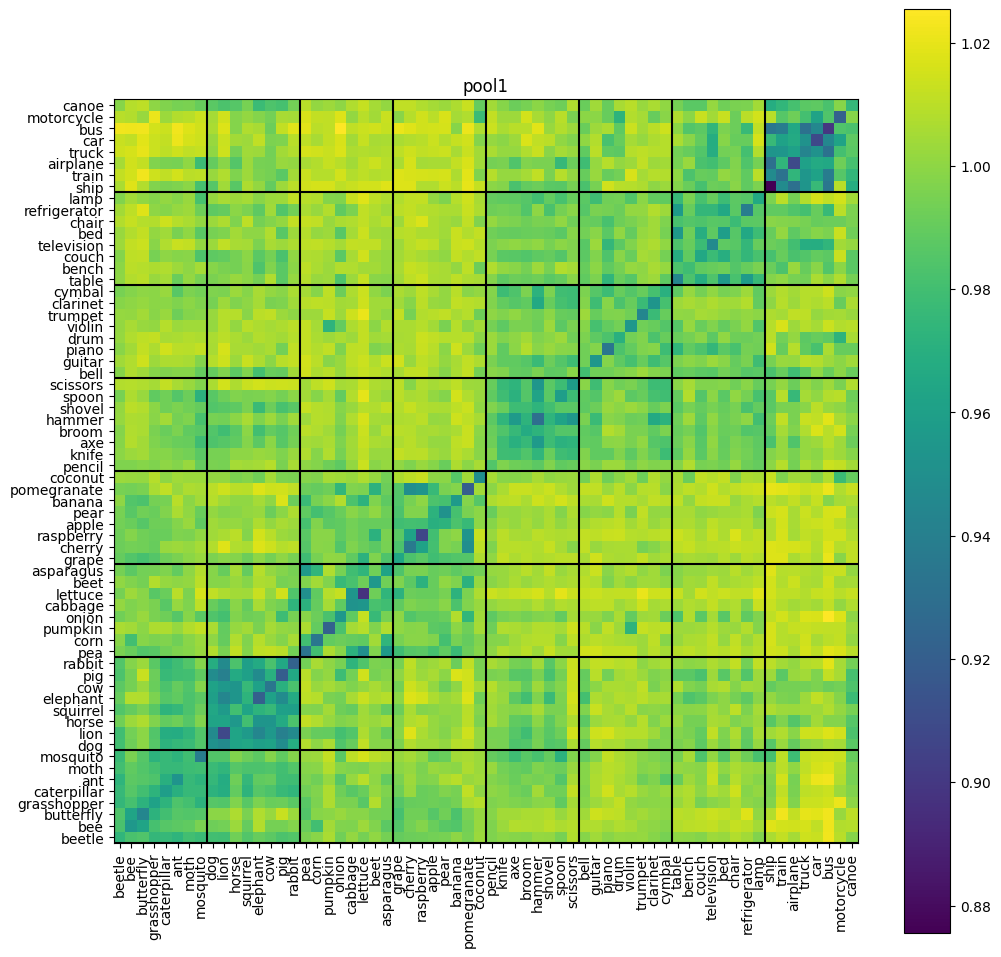

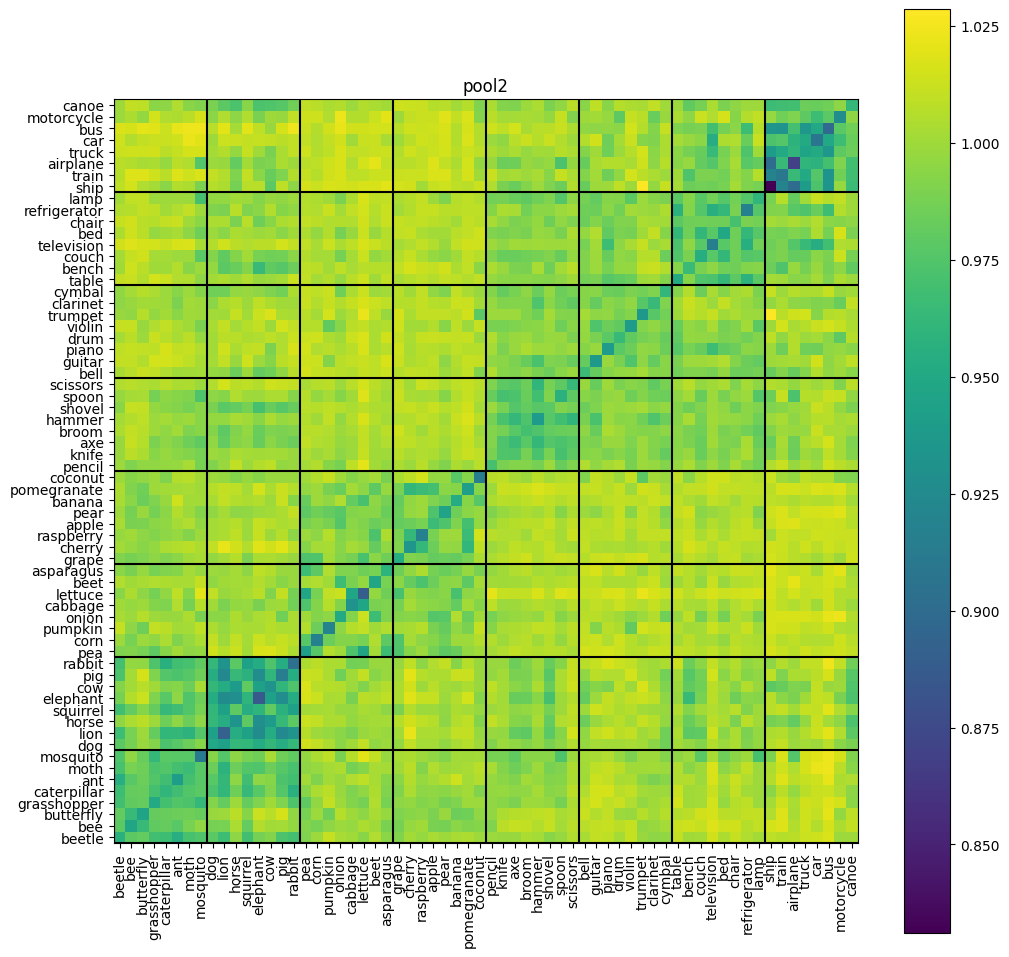

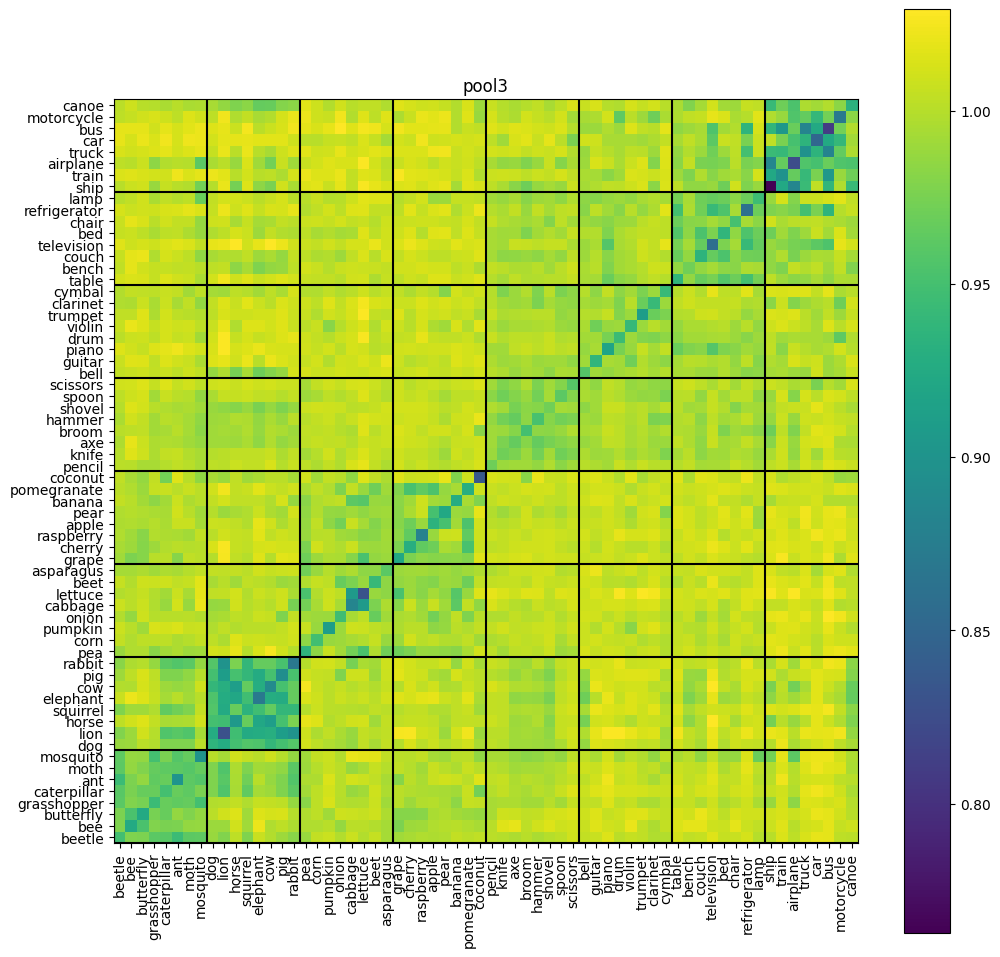

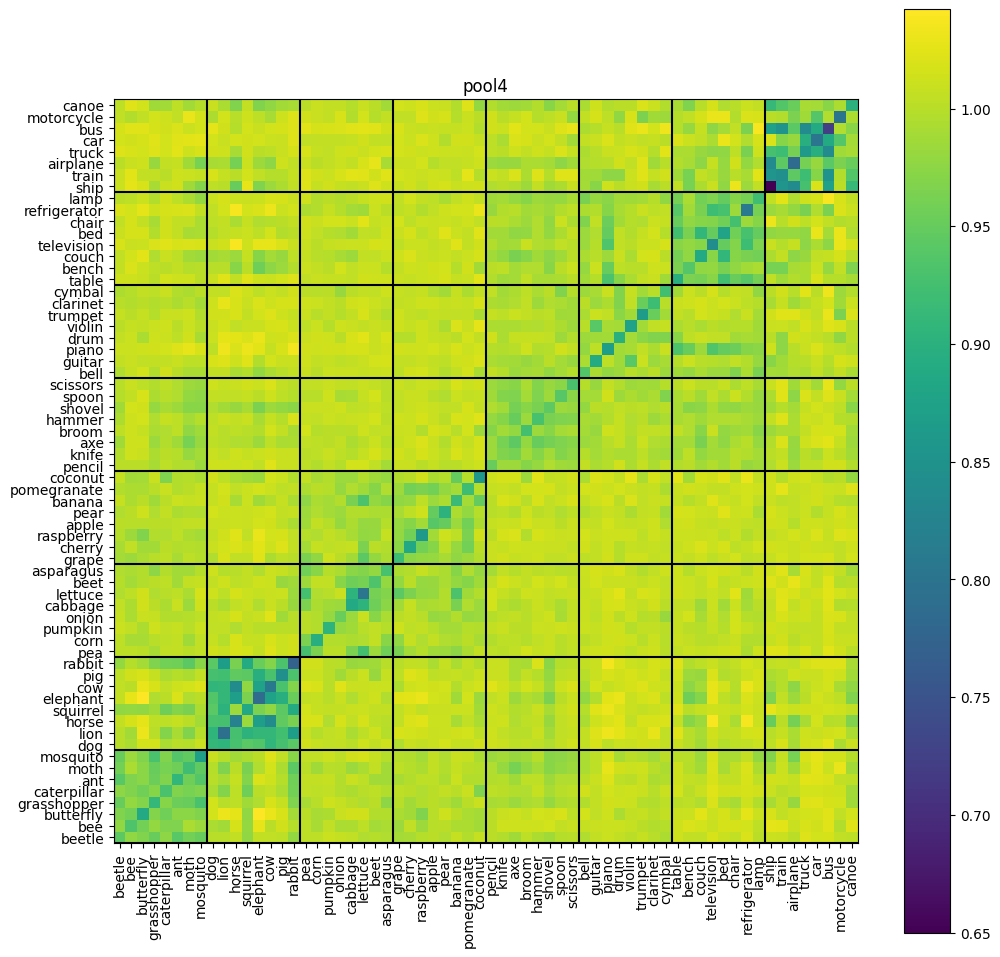

In [8]:
for ll in range(n_layers):
    
    
    d = b_pair_dist[:,:,ll]
    
    plt.figure(figsize=(12, 12))
    plt.pcolormesh(d, \
                   # vmin=0.37, vmax=1.10, \
                  )
    plt.xticks(np.arange(n_basic)+0.5, basic_names, rotation=90)
    plt.yticks(np.arange(n_basic)+0.5, basic_names)
    
    for si in range(n_super):
        plt.axhline(si*n_basic_each_super, color='k')
        plt.axvline(si*n_basic_each_super, color='k')
    
    plt.axis('square')
    plt.colorbar()

    plt.title(layer_names[ll])

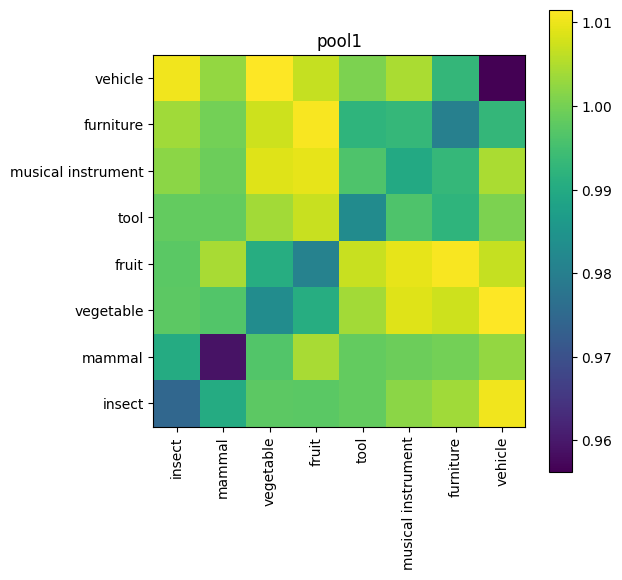

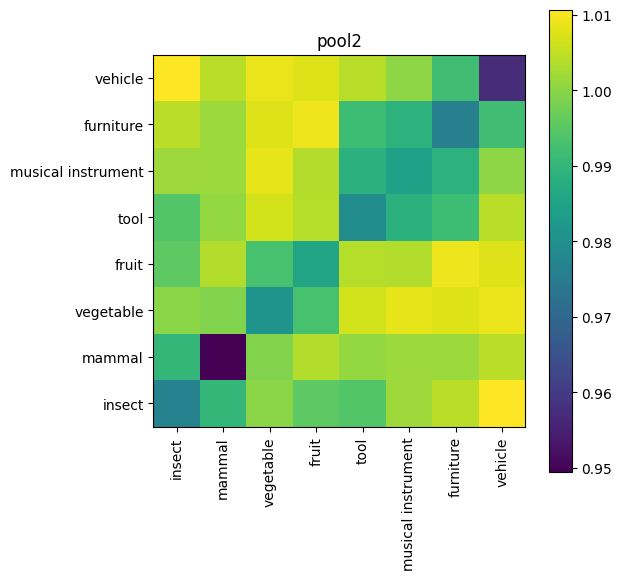

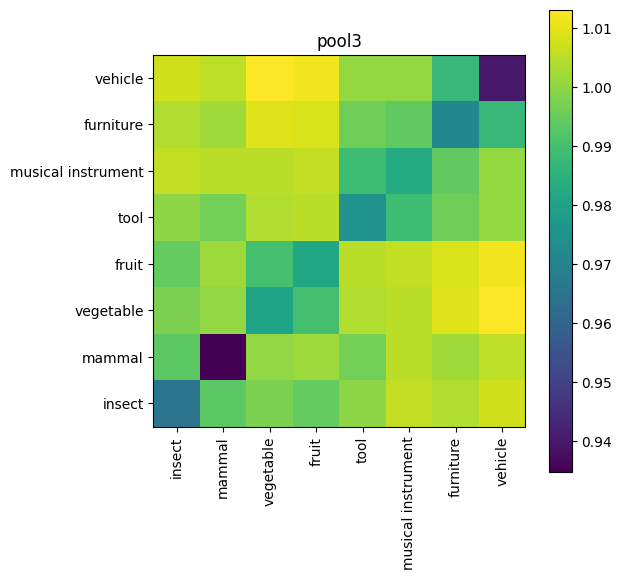

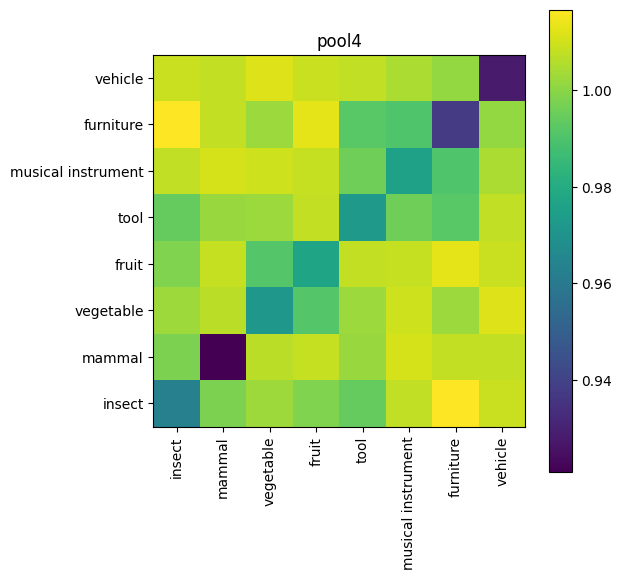

In [11]:
for ll in range(n_layers):
    
    
    d = s_pair_dist[:,:,ll]
    
    plt.figure(figsize=(6,6))
    plt.pcolormesh(d, \
                   # vmin=0.37, vmax=1.10, \
                  )
    plt.xticks(np.arange(n_super)+0.5, super_names, rotation=90)
    plt.yticks(np.arange(n_super)+0.5, super_names)
    
    # for si in range(n_super):
    #     plt.axhline(si*n_basic_each_super, color='k')
    #     plt.axvline(si*n_basic_each_super, color='k')
    
    plt.axis('square')
    plt.colorbar()

    plt.title(layer_names[ll])